15.09.2022: implemented the code below but still needs to be tested

In [2]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from openslide import OpenSlide
from skimage.morphology import binary_erosion
from skimage.draw import disk
from scipy.ndimage import zoom
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label, regionprops

# annotation_path = Path('/home/rens/hpc/rens/annotations/isala/metastasis/PREM-IS-005_4742fe58bd I2 HE1 - 2022-03-24 19.40.03.xml')
# slide_path = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-005_4742fe58bd I2 HE1 - 2022-03-24 19.40.03.ndpi')

annotation_path = '/home/rens/hpc/rens/annotations/rough/PREM-IS-001_d8910ad17c I1 HE1 - 2022-03-24 19.55.56.xml'
slide_path = '/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-001_d8910ad17c I1 HE1 - 2022-03-24 19.55.56.ndpi'

level = 6
threshold = 680 

roi_margin = 500 # micrometer
background_margin = 100 # micrometer

def dilate(mask, radius):
    edges = mask - binary_erosion(mask)

    expanded = edges.copy()

    for x,y in zip(np.where(edges)[0].tolist(), np.where(edges)[1].tolist()):
        x,y = disk((x, y), radius)

        x,y = x[x > 0], y[x > 0]
        x,y = x[x < mask.shape[0]], y[x < mask.shape[0]]

        x,y = x[y > 0], y[y > 0]
        x,y = x[y < mask.shape[1]], y[y < mask.shape[1]]

        mask[x,y] = 1

    return mask

def post_process_annotation(
    slide_path, annotation_path, save_path, 
    roi_margin=500, background_margin=100, level=6, 
    threshold=680, number_of_background_regions=3, 
    correct_for_dirt=True, verbose=False):

    

    slide = OpenSlide(str(slide_path))

    factor = slide.level_dimensions[level][0] / slide.level_dimensions[0][0]
    x_spacing = slide.properties['openslide.mpp-x']
    y_spacing = slide.properties['openslide.mpp-y']

    assert x_spacing[:6] == y_spacing[:6]

    roi_margin /= float(x_spacing) / factor
    background_margin /= float(x_spacing) / factor

    # determine ROI based on annotation
    if verbose: print('determining ROI based on annotation...')

    with open(annotation_path, 'r') as f:
        xml_file = ET.parse(f)

    rois = []
    for annotation in xml_file.getroot()[0]:
        roi = []
        for coordinate in annotation[0]:
            roi.append([coordinate.attrib['X'], coordinate.attrib['Y']])
        rois.append(np.array(roi).astype(float).astype(int))

    mask = np.zeros(np.flip(slide.level_dimensions[0]), dtype=np.uint8)
    cv2.fillPoly(mask, rois,1)


    reduced_mask = zoom(mask, factor, mode='nearest', order=0)

    roi = dilate(reduced_mask, roi_margin)

    if verbose:
        plt.figure()
        plt.title('ROI')
        plt.imshow(roi)
        plt.show()

    # determine what is background based on slide image
    
    if verbose: print('opening slide...')
    img = np.array(slide.read_region((0,0), level, slide.level_dimensions[level]).convert('RGB'))

    if verbose:
        print('determining background based on slide image...')
        plt.figure()
        plt.title('Slide')
        plt.imshow(img)
        plt.show()

    tile_width = int(slide.properties[f'openslide.level[{level + 1}].tile-width'])
    tile_height = int(tile_width * 1.2)

    if correct_for_dirt:
        # correct for a dirty lens
        avg_patch = np.zeros((tile_height, tile_width, 3))
        n_patches = 0
        for x in np.arange(0, slide.level_dimensions[level][0], tile_width):
            for y in np.arange(0, slide.level_dimensions[level][1], tile_height):
                avg_patch = avg_patch + img[y:y+tile_height, x:x+tile_width]
                n_patches += 1

        avg_patch = avg_patch / n_patches
        patch_delta = avg_patch - avg_patch.max(axis=(0,1))

        slide_delta = np.tile(
            patch_delta, 
            (
                int(slide.level_dimensions[level][1] / tile_height),
                int(slide.level_dimensions[level][0] / tile_width),
                1
            )
        )
        regions = label(((img - slide_delta).sum(axis=-1) > threshold).astype(int))
    else:
        regions = label((img.sum(axis=-1) > threshold).astype(int))

    props = regionprops(regions)
    props = sorted(props, key=lambda x: x.area, reverse=True)
    background_regions = props[:number_of_background_regions]

    background = np.zeros(regions.shape)
    for region in background_regions:
        background[np.where(regions == region.label)] = 1

    background = dilate(background, background_margin)

    if verbose:
        plt.figure()
        plt.title('Background')
        plt.imshow(background)
        plt.show()

    # remove background
    roi = roi * (background == 0).astype(int)

    if verbose:
        plt.figure()
        plt.title('Final annotation')
        plt.imshow(roi)
        plt.show()

    # convert to xml file
    if verbose: print('saving...')
    contours, _ = cv2.findContours(roi.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    annotations = ''
    for ix, contour in enumerate(contours):
        start_of_annotation = f'''\t\t<Annotation Name="Annotation {ix}" Type="Polygon" PartOfGroup="None" Color="#F4FA58">
        \t\t<Coordinates>
        '''

        coordinates=''
        for jx, (x,y) in enumerate(contour[:,0]):
            if ix == 0:
                coordinate = f'\t\t\t<Coordinate Order="{jx}" X="{x/factor}" Y="{y/factor}" />\n'   
            else:
                coordinate = f'\t\t\t\t<Coordinate Order="{jx}" X="{x/factor}" Y="{y/factor}" />\n'
            coordinates += coordinate

        end_of_annotation = '''\t\t\t</Coordinates>
        \t</Annotation>'''

        annotations += start_of_annotation + coordinates + end_of_annotation

    start_of_document = '''<?xml version="1.0"?>
    <ASAP_Annotations>
    \t<Annotations>
    '''

    end_of_document = '''
    \t</Annotations>
    </ASAP_Annotations>
    '''

    xml = start_of_document + annotations + end_of_document

    with open(save_path, 'w') as f:
        f.write(xml)

In [3]:
annotation_r = Path('/home/rens/hpc/rens/annotations/automatic_annotations/rough/')
slides_r = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/')
target_dir = Path('/home/rens/hpc/rens/annotations/automatic_annotations/core_and_context')

/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-067_7bb9695ab8 I1 HE1 - 2022-03-24 18.22.43.xml
determining ROI based on annotation...


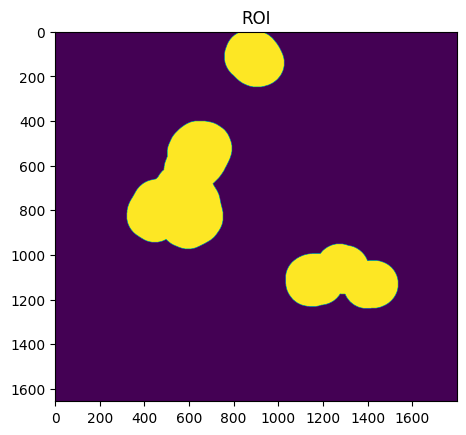

opening slide...
determining background based on slide image...


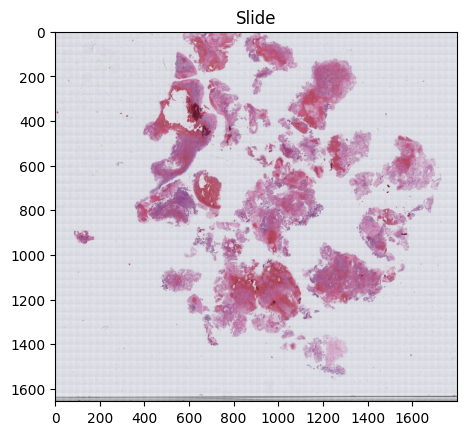

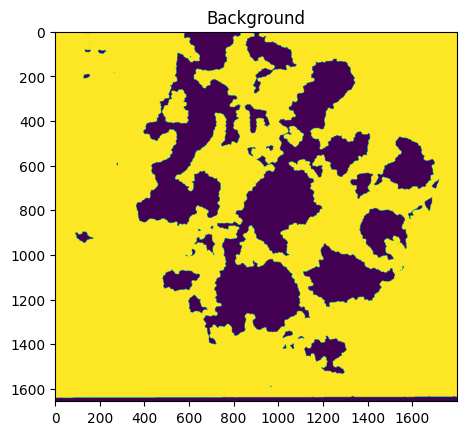

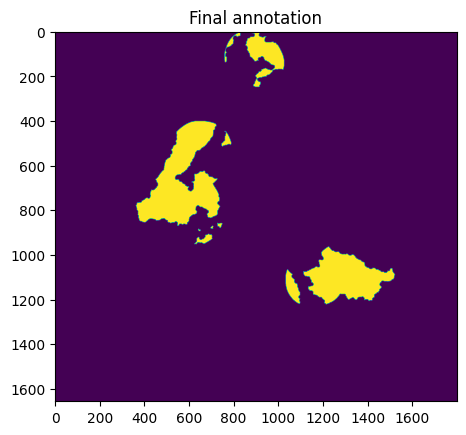

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-069_bf802036ef I2 HE1 - 2022-03-24 17.25.00.xml
determining ROI based on annotation...


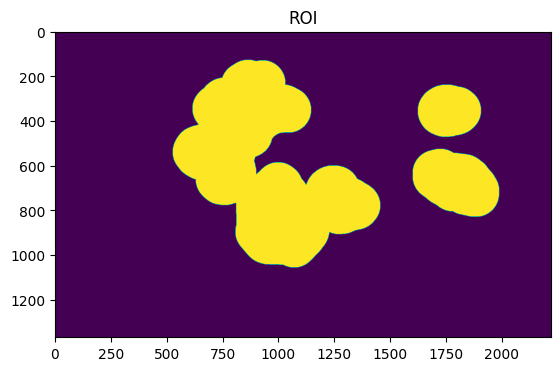

opening slide...
determining background based on slide image...


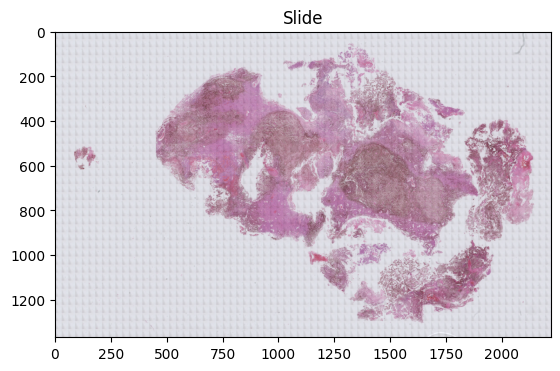

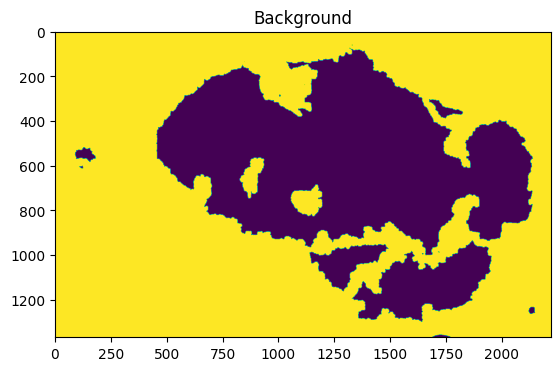

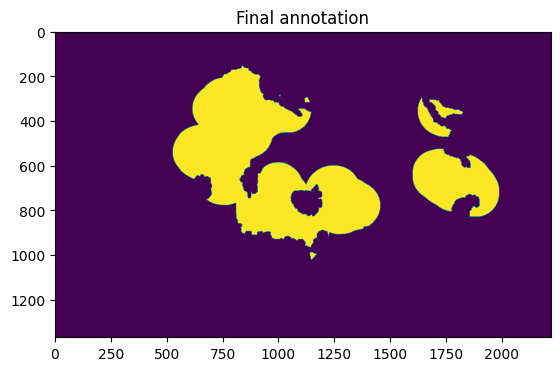

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-072_9a93d03be8 I1 HE1 - 2022-03-24 17.29.50.xml
determining ROI based on annotation...


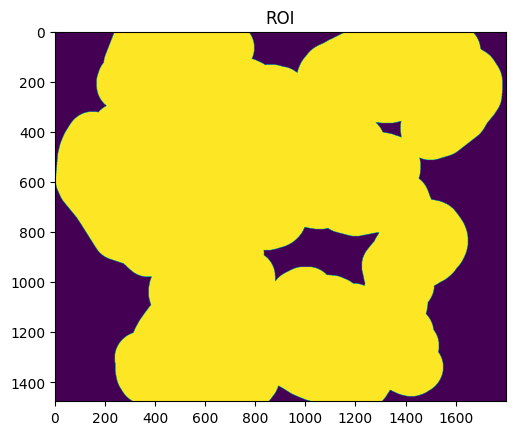

opening slide...
determining background based on slide image...


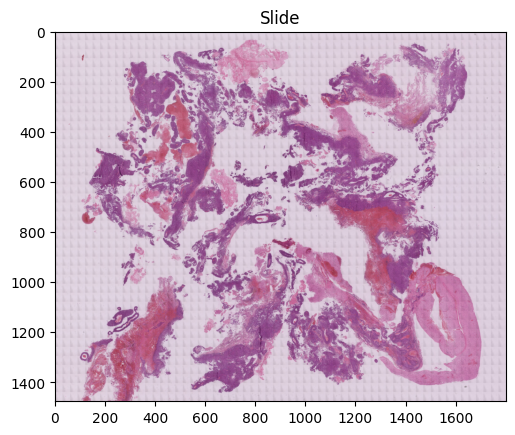

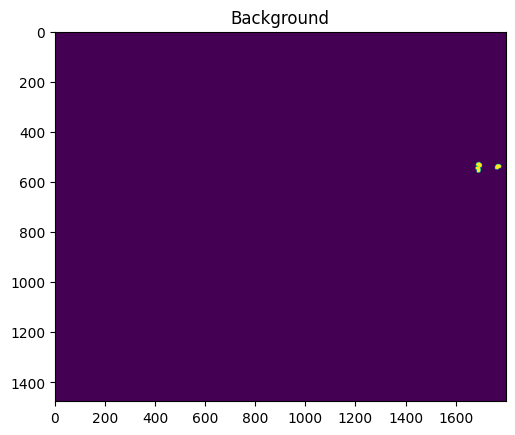

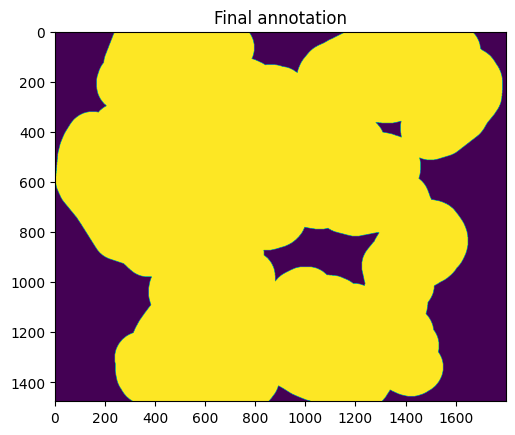

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-075_6d2039bb4d I3 HE1 - 2022-03-24 19.57.33.xml
determining ROI based on annotation...


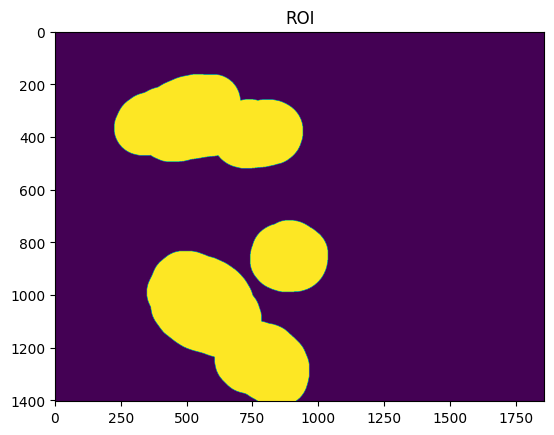

opening slide...
determining background based on slide image...


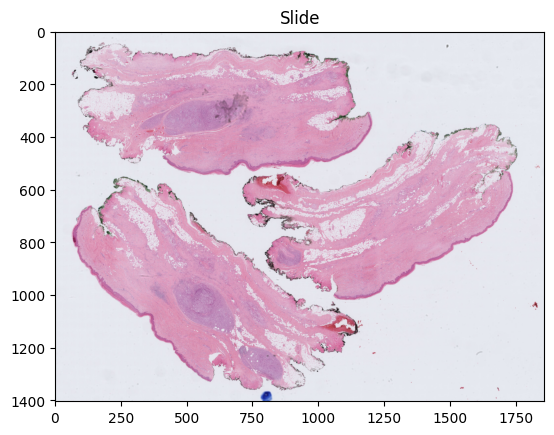

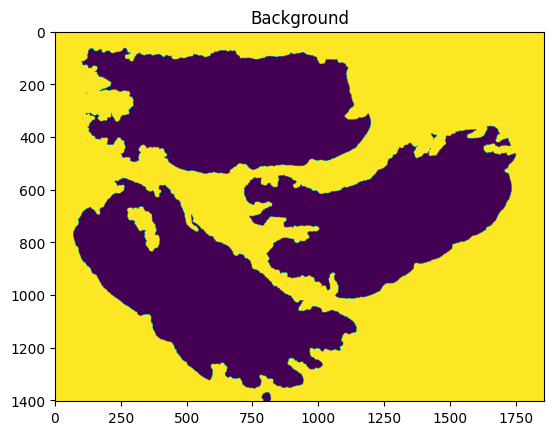

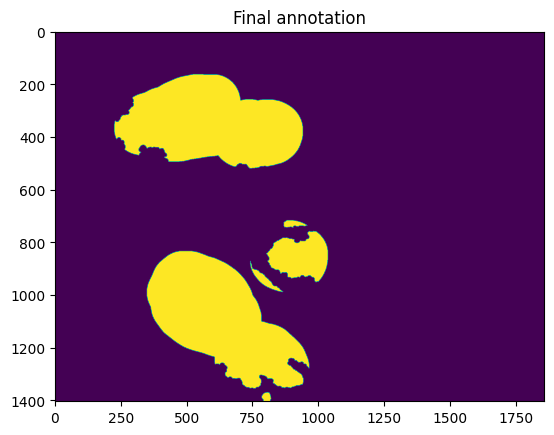

saving...


In [7]:
for annotation_path in sorted(list(annotation_r.iterdir()))[7:]:
    print(annotation_path)
    slide_path = slides_r / (annotation_path.stem + '.ndpi')
    save_path = target_dir / (annotation_path.stem + '.xml')
    
    post_process_annotation(
        slide_path,
        annotation_path,
        save_path,
        roi_margin=1500,
        background_margin=100,
        correct_for_dirt=True,
        verbose=True
    )

/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-067_7bb9695ab8 I1 HE1 - 2022-03-24 18.22.43.xml
determining ROI based on annotation...


/home/rens/anaconda3/envs/rens/lib/python3.10/site-packages/skimage/draw/draw.py:41: RuntimeWarning: invalid value encountered in true_divide
  distances = ((r * cos_alpha + c * sin_alpha) / r_rad) ** 2 \
/home/rens/anaconda3/envs/rens/lib/python3.10/site-packages/skimage/draw/draw.py:42: RuntimeWarning: invalid value encountered in true_divide
  + ((r * sin_alpha - c * cos_alpha) / c_rad) ** 2


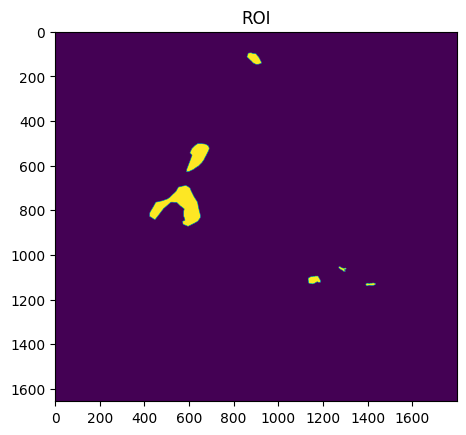

opening slide...
determining background based on slide image...


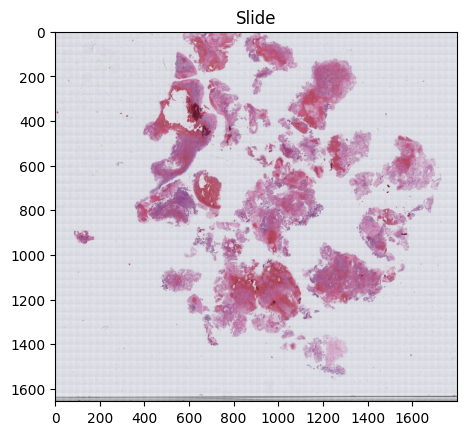

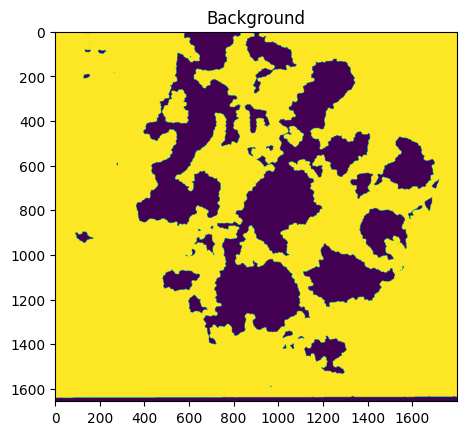

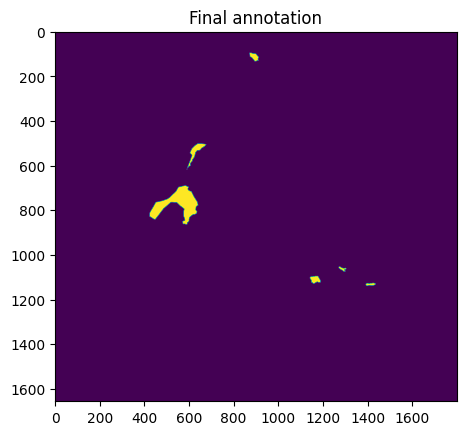

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-069_bf802036ef I2 HE1 - 2022-03-24 17.25.00.xml
determining ROI based on annotation...


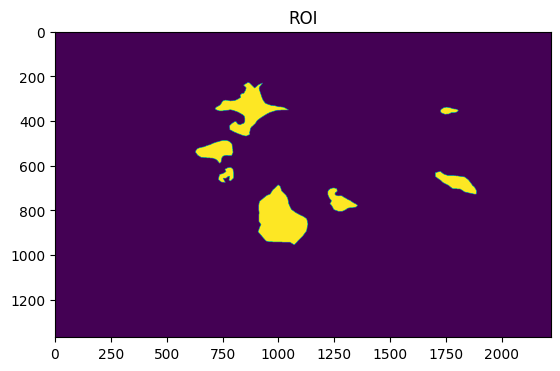

opening slide...
determining background based on slide image...


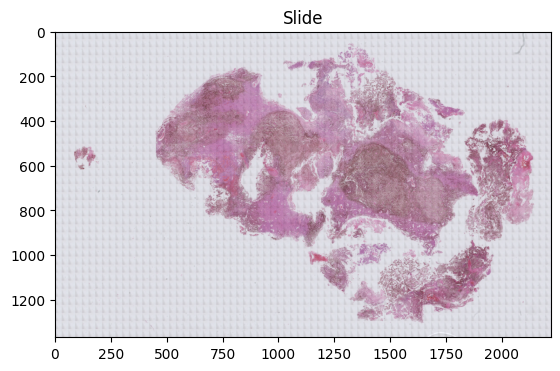

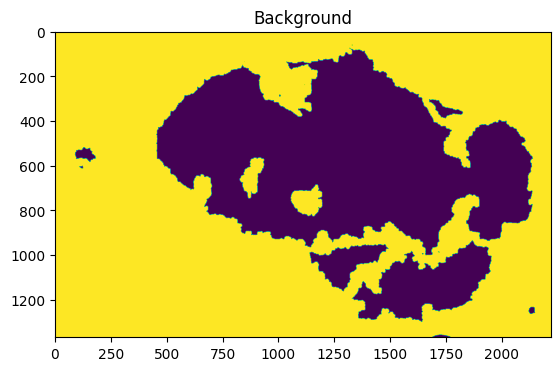

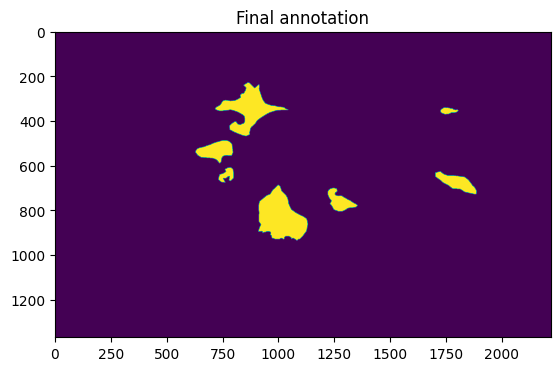

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-072_9a93d03be8 I1 HE1 - 2022-03-24 17.29.50.xml
determining ROI based on annotation...


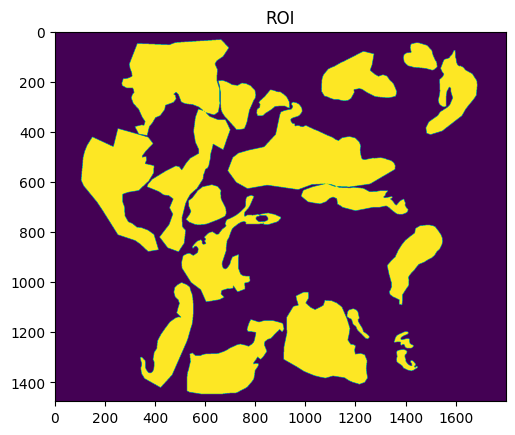

opening slide...
determining background based on slide image...


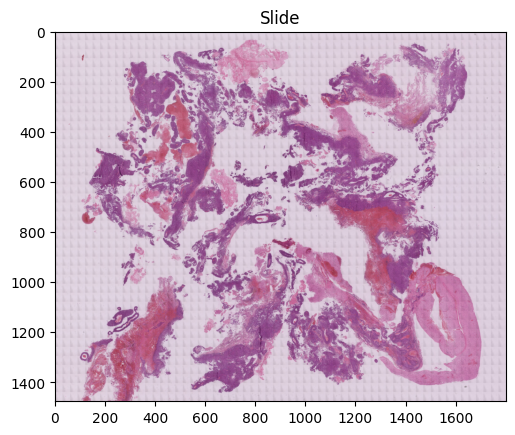

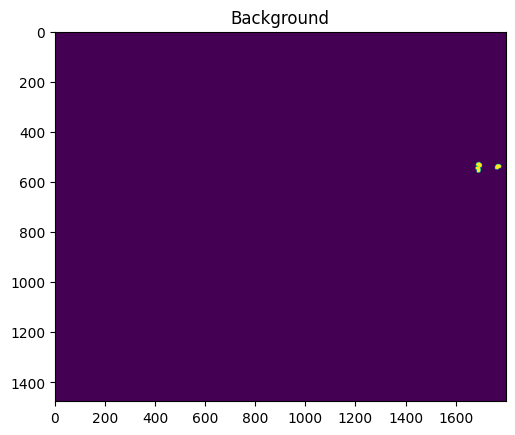

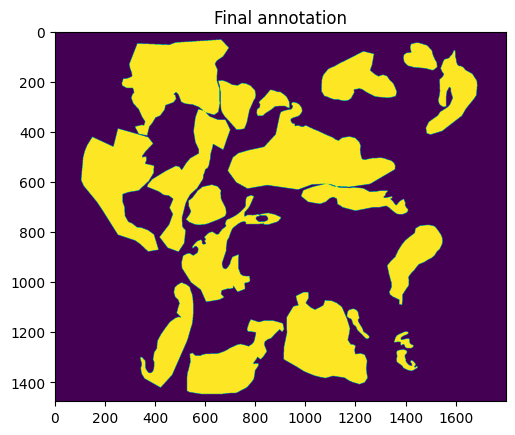

saving...
/home/rens/hpc/rens/annotations/automatic_annotations/rough/PREM-IS-075_6d2039bb4d I3 HE1 - 2022-03-24 19.57.33.xml
determining ROI based on annotation...


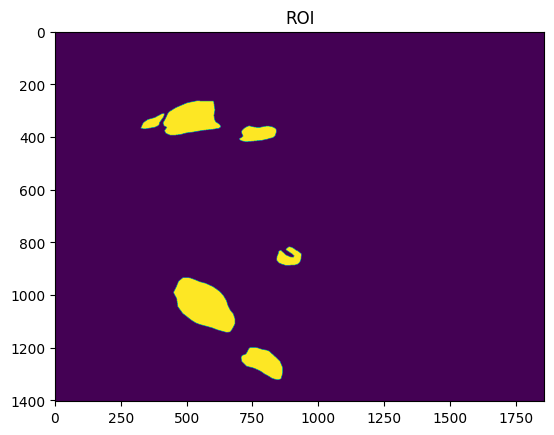

opening slide...
determining background based on slide image...


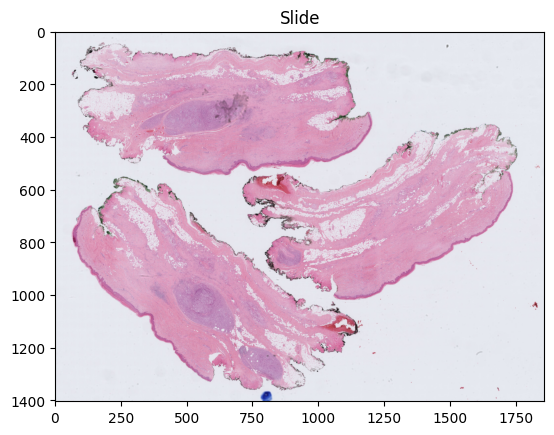

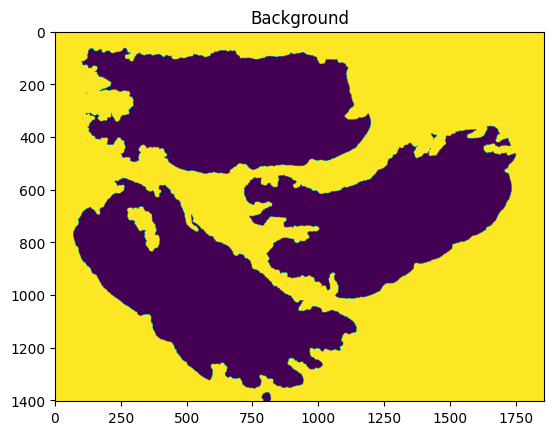

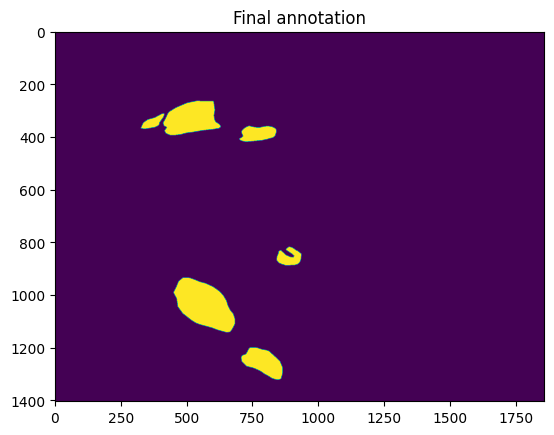

saving...


In [6]:
annotation_r = Path('/home/rens/hpc/rens/annotations/automatic_annotations/rough/')
slides_r = Path('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/')
target_dir = Path('/home/rens/hpc/rens/annotations/automatic_annotations/core_only')

for annotation_path in sorted(list(annotation_r.iterdir()))[7:]:
    print(annotation_path)
    slide_path = slides_r / (annotation_path.stem + '.ndpi')
    save_path = target_dir / (annotation_path.stem + '.xml')
    
    post_process_annotation(
        slide_path,
        annotation_path,
        save_path,
        roi_margin=0,
        background_margin=100,
        correct_for_dirt=True,
        verbose=True
    )

In [114]:
slide = OpenSlide('/home/rens/hpc/PREMIUM histopathology/data/isala/metastasis/PREM-IS-016_e0d59b6d80 I6 HE1 - 2022-03-24 17.02.40.ndpi')

level = 6
img = np.array(slide.read_region((0,0), level, slide.level_dimensions[level]).convert('RGB'))

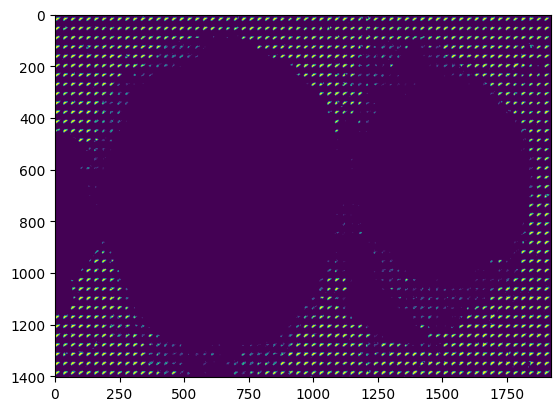

In [115]:
plt.imshow(img.sum(axis=-1) > threshold)
plt.show()

In [116]:

tile_width = int(slide.properties[f'openslide.level[{level + 1}].tile-width'])
tile_height = int(tile_width * 1.2)

In [150]:
avg_patch = np.zeros((tile_height, tile_width, 3))
n_patches = 0
for x in np.arange(0, slide.level_dimensions[level][0], tile_width):
    for y in np.arange(0, slide.level_dimensions[level][1], tile_height):
        avg_patch = avg_patch + img[y:y+tile_height, x:x+tile_width]
        n_patches += 1

avg_patch = avg_patch / n_patches
patch_delta = avg_patch - avg_patch.max(axis=(0,1))

slide_delta = np.tile(
    patch_delta, 
    (
        int(slide.level_dimensions[level][1] / tile_height),
        int(slide.level_dimensions[level][0] / tile_width),
        1
    )
)

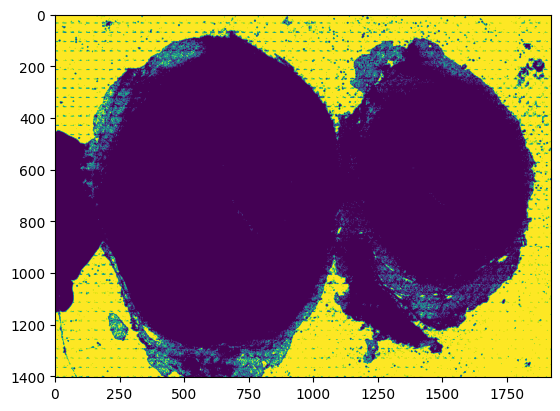

In [158]:
plt.imshow((img - slide_delta).sum(axis=-1) > threshold)
plt.show()

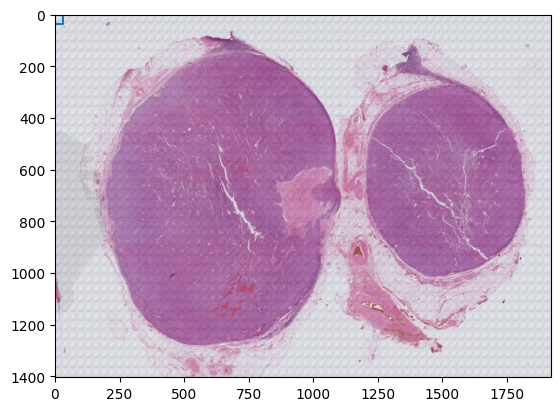

In [123]:
plt.imshow(img)
plt.plot(
    [0,0,tile_width, tile_width,0],
    [0,tile_height, tile_height, 0, 0]
)
plt.show()

In [41]:
tile_height

36

In [42]:
tile_width

30